# Intensity along the track 

## Dependencies

In [1]:
import astropy.io.fits as fits
import scipy
from scipy import ndimage
from scipy.optimize import curve_fit, leastsq
from matplotlib import pyplot as plt
import numpy as np
from detectsat.utils.mosaic import *
import imageio as imgio
import math
from random import randrange

## Sinus Function

In [2]:
def sinus(angle, ampl, freq, phase_shift, vertical_shift):
    return ampl*np.sin(freq*math.pi*2*angle+phase_shift)+vertical_shift

## Utils Functions 

In [3]:
def createImage(name, array):
    imgio.imwrite(name, array)

In [4]:
def showGraph(array):
    plt.plot(array)
    plt.show()

In [5]:
def createFitsFile(name, array):
    hdu = fits.PrimaryHDU(array)
    hdu.writeto(name+'.fits')

## Add the line on the data

In [6]:
def addLineOnData(line, data):
    #For the first block of the fits file (bottom left)
    min_x, min_y = 100, 100
    max_x, max_y = 2000, 4000
    height, width = np.shape(line)
    new_data = data.copy()
    #print(data[min_y:min_y+height_line, min_x:min_x+width_line])
    new_data[min_y:min_y+height, min_x:min_x+width] += line[:,:]
    #print('-----------------------')
    #print(data[min_y:min_y+height_line, min_x:min_x+width_line])
    return new_data

## Find the intensity along the track

In [7]:
def findIntensityAlongTheLine(data, height_line, width_line, start_line_x, start_line_y):
    intensities = []
    for i in range(width_line):
        intensity_for_this_x = 0
        for j in range(height_line):
            intensity_for_this_x += data[start_line_y+j,start_line_x+i]
        intensities.append(intensity_for_this_x)
        #intensities.append(intensity_for_this_x/height_line)



    fig, ax = plt.subplots(1, 2)
    ax = ax.flatten()
    ax[0].plot(intensities)
    ax[0].set_title("Original signal")

    intensities_fft = np.fft.fft(intensities)
    intensities_fft = intensities_fft[:round(width_line/2)]
    intensities_fft = np.abs(intensities_fft)
    intensities_fft[0] = 0
    intensities_fft = intensities_fft/max(intensities_fft)
    freq_x_axis = np.linspace(0, width_line/2, len(intensities_fft))
    
    ax[1].plot(freq_x_axis, intensities_fft, "o-")
    ax[1].set_title("Frequency magnitudes")
    ax[1].set_xlabel("Frequency")
    ax[1].set_ylabel("Magnitude")
    
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    bp=intensities_fft[:]
    ibp=scipy.ifft(bp)
    
    intensities_fft_test = np.fft.fft(ibp)
    intensities_fft_test = intensities_fft_test[:round(width_line/2)]
    intensities_fft_test = np.abs(intensities_fft_test)
    intensities_fft_test[0] = 0
    intensities_fft_test = intensities_fft_test/max(intensities_fft_test)
    
    showGraph(ibp)
    print("Inverse Fourier signal")
    print('')
    
    f_loc = np.argmax(intensities_fft_test) # Finds the index of the max
    
    while f_loc > 100:
        intensities_fft_test[f_loc] = 0
        f_loc = np.argmax(intensities_fft_test)
    
    f_val = freq_x_axis[f_loc] # The strongest frequency value
    
    print(f"The strongest frequency is f = {f_val}")

    guess_mean = np.mean(intensities)
    #guess_std = 3*np.std(intensities)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = f_val/width_line
    guess_amp = 0
    

    x_val = np.arange(width_line)
    showGraph(np.transpose(intensities))
    params, _ = curve_fit(sinus, x_val, intensities, [guess_amp, guess_freq, guess_phase, guess_mean])
    print(params)
    
    plt.scatter(x_val, intensities, label='Data')
    plt.plot(x_val, sinus(x_val, params[0], params[1], params[2], params[3]), color='red', label='Fitted function')
    plt.legend(loc='best')
    plt.show()

    
    #https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    #intensities_fft = np.fft.fft(intensities)
    #intensities_fft = intensities_fft[:round(width_line/2)]
    #intensities_fft = np.abs(intensities_fft)
    #intensities_fft = intensities_fft/max(intensities_fft)

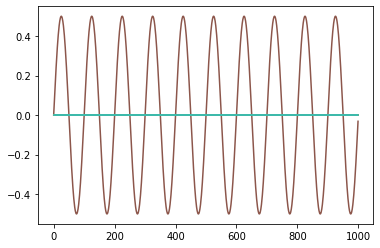

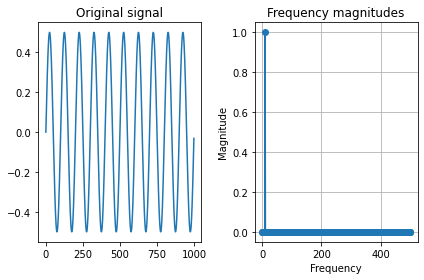

/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


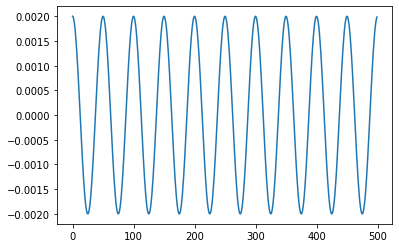

Inverse Fourier signal

The strongest frequency is f = 10.020040080160319


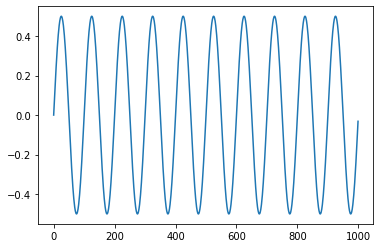

[ 5.00000000e-01  1.00000000e-02 -1.26582134e-08 -1.44909153e-10]


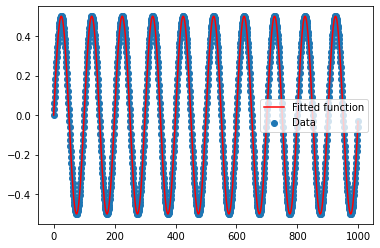

In [8]:
def test_line(): 
    ampl, freq, phase_shift, vertical_shift = 0.5, 0.01, 0, 0
    radius = 15
    width_line = 1000
    height_line = 2*radius
    line = np.zeros((height_line, width_line))
    for i in range(height_line):
        for j in range(width_line):
            if(i == round(height_line/2)):
                line[i,j] = sinus(j, ampl, freq, phase_shift, vertical_shift)
                
    showGraph(np.transpose(line))
    findIntensityAlongTheLine(line, height_line, width_line, 0, 0)
    
test_line()

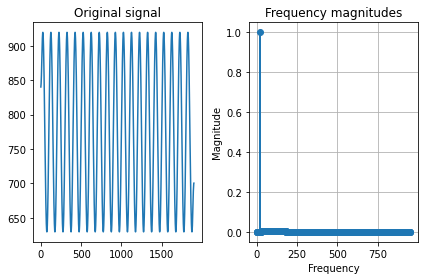

/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


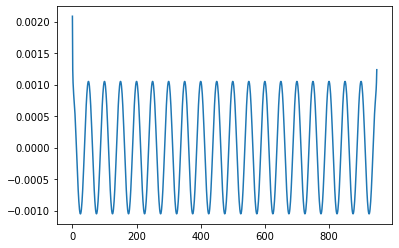

Inverse Fourier signal

The strongest frequency is f = 19.020021074815595


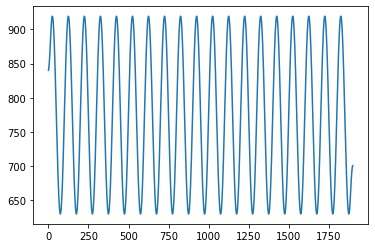

[1.45108799e+02 9.99755291e-03 5.00262055e-02 7.74433257e+02]


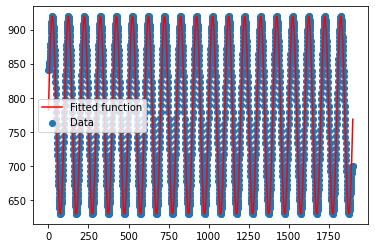

In [9]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
x_star,y_star = 1665,8346
radius = 15
height = 2000
width_line = 1900
height_line = 2*radius
#value = 0.02 #number1
value = 0.01 #number2
#value = 0.008 #number3
#value = 0.008
#ampl, freq, phase_shift, vertical_shift = 0.01, 0.01, 0, 0.5 #number1
ampl, freq, phase_shift, vertical_shift = 0.05, 0.01, 0, 3 #number2
#ampl, freq, phase_shift, vertical_shift = 0.03, 0.01, 0, 2.5 #number3
#ampl, freq, phase_shift, vertical_shift = 0.03, 0.01, 0, 2.5

data = fits.open(name_file)[0].data
star = data[y_star-radius:y_star+radius, x_star-radius:x_star+radius]
line = np.zeros((height_line, width_line))

for i in range(height_line):
    for j in range(width_line):
        if(i == round(height_line/2)):
            #line[i,j] = sinus(j, ampl, period, phase_shift, vertical_shift)
            line[i,j] = value*sinus(j, ampl, freq, phase_shift, vertical_shift)

line_convolved = ndimage.convolve(line, star)
line_convolved[-1,:] = line_convolved[0,:]
#line_convolved[:,:] = line_convolved[:,:]-(51.4*2) #number1
line_convolved[:,:] = line_convolved[:,:]-(51.4*6) #number2
#line_convolved[:,:] = line_convolved[:,:]-(51.4*4) #number3
findIntensityAlongTheLine(line_convolved, height_line, width_line, 0, 0)
#createImage('line_convolved.png',line_convolved)

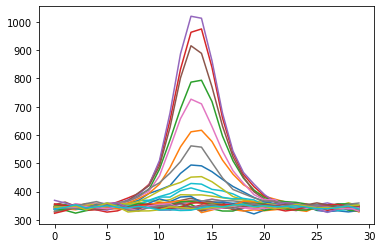

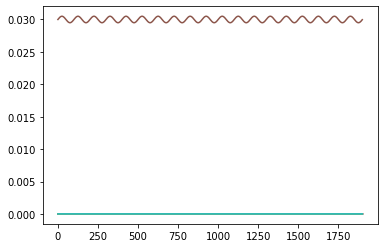

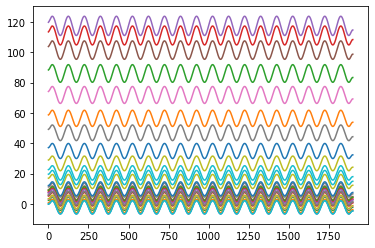

In [10]:
showGraph(np.transpose(star))
showGraph(np.transpose(line))
showGraph(np.transpose(line_convolved))

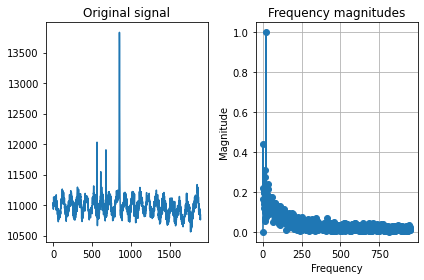

/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


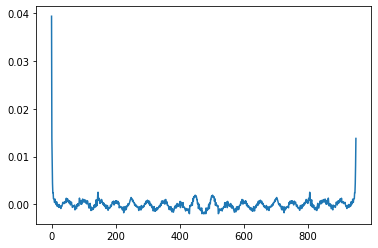

Inverse Fourier signal

The strongest frequency is f = 19.020021074815595


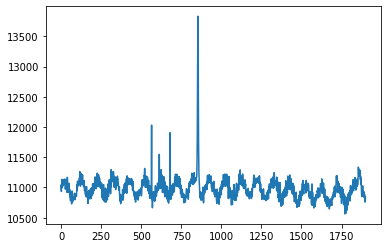

[ 1.32194450e+02  9.97116447e-03 -2.84611968e-02  1.09818126e+04]


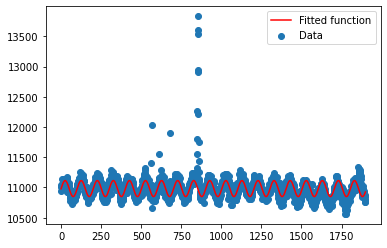

In [11]:
data_with_line = addLineOnData(line_convolved, data)
findIntensityAlongTheLine(data_with_line, height_line, width_line, 100, 100)

In [54]:
scaled_data = scale_image(data_with_line[::-1].copy())
createImage('try_image_line.png', scaled_data)

/Users/noah/Desktop/EPFL/BA6/Projet Bachelor/bachelor-project/detectsat/utils/mosaic.py:51: RuntimeWarning: invalid value encountered in greater
  raw_img[raw_img > z2] = z2
/Users/noah/Desktop/EPFL/BA6/Projet Bachelor/bachelor-project/detectsat/utils/mosaic.py:52: RuntimeWarning: invalid value encountered in less
  raw_img[raw_img < z1] = z1
Lossy conversion from >f8 to uint8. Range [308.9854434077432, 399.421639764574]. Convert image to uint8 prior to saving to suppress this warning.


## Rotation of the generated line

In [12]:
def get_line_values_with_mask(mask, data, x_start, y_start):
    height, width = np.shape(mask)
    line_values = mask.copy()
    #print(data[min_y:min_y+height_line, min_x:min_x+width_line])
    line_values[:] = mask[:,:]*data[y_start:y_start+height, x_start:x_start+width]
    return line_values

In [17]:
radius = 15
width_line = 1900
height_line = 2*radius
#angle = randrange(0,359)
angle = 11
#angle = 339 interesting because cross a star
print('angle : '+str(angle))
line_rotated = ndimage.rotate(line_convolved, angle, reshape='False')
data_with_rotated_line = addLineOnData(line_rotated, data)
#scaled_data_rot = scale_image(data_with_rotated_line[::-1].copy())
#createImage('try_image_line_rotated.png', scaled_data_rot)
#findIntensityAlongTheLine(data_with_line, height_line, width, 100, 100)
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data_with_rotated_line, 100, 100)
createImage('line_from_image.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle, reshape='False')
#createImage('line_from_image_rot.png', line_from_image_rot)
#scaled_data_rot = scale_image(line_from_image_rot[::-1].copy())
#createImage('rot.png', scaled_data_rot)
#print(line_from_image_rot)

angle : 11


Lossy conversion from float64 to uint8. Range [0.0, 1185.0388634366643]. Convert image to uint8 prior to saving to suppress this warning.


(1605, 1925)


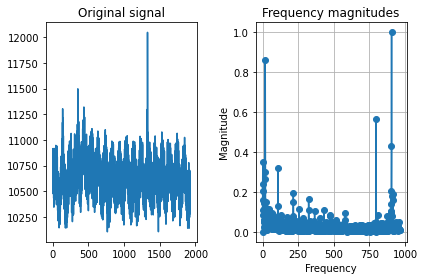

/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


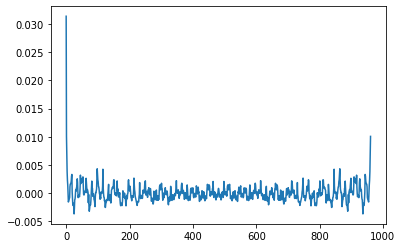

Inverse Fourier signal

The strongest frequency is f = 19.02965660770031


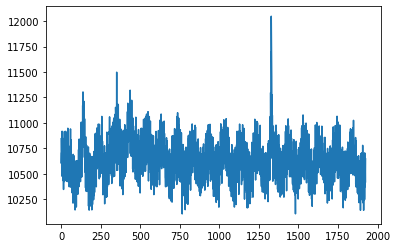

[ 1.45606550e+02  9.99290948e-03 -7.16625045e-01  1.06304430e+04]


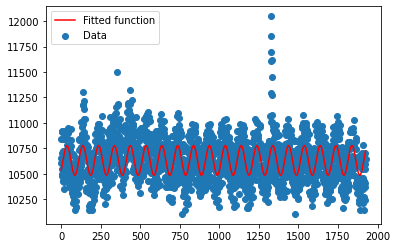

In [57]:
print(np.shape(line_from_image_rot))
for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

In [35]:
def get_blocks_addresses(raw_img):
    """
    Isolating the 32 blocks of the mosaic by registering for each block
    the indices of their corners

    Parameters
    ----------
    raw_img : numpy.array(np.float32)
        Zscaled mosaic
    Return
    ----------
    crops_addresses : dict
    """
    # Maybe there is a problem with this part for the new fits files
    nans = np.argwhere(np.isnan(raw_img))
    bunches = nans[(nans[:,1] == 0) | (nans[:,0] == 0)]
    cuts_y = []
    cuts_x = []
    temp_y = -1
    temp_x = -1
    for i in bunches :
        x,y = tuple(i)
        if x == 0 :
            if abs(y - temp_y) > 1:
                cuts_y.append([temp_y+1, y])
            temp_y = y
        if y == 0:
            if abs(x - temp_x) > 1:
                cuts_x.append([temp_x+1, x])
            temp_x = x
    cuts_x.append([temp_x+1, raw_img.shape[0]])
    cuts_y.append([temp_y+1, raw_img.shape[1]])
    cuts_y = np.array(cuts_y)
    cuts_x = np.array(cuts_x)
    crops_addresses = {}
    current_study_x = cuts_x
    current_study_y = cuts_y
    for t_x in current_study_x:
        min_x, max_x = tuple(t_x)
        list_tx = [tuple(t_x)]
        if max_x - min_x > 7000:
            tmp_middle = int((max_x + min_x) / 2)
            list_tx = [(min_x, tmp_middle), (tmp_middle, max_x)]
        for sub_tx in list_tx:
            crops_addresses[sub_tx] = []
            for t_y in current_study_y:
                 crops_addresses[sub_tx].append(tuple(t_y))

    return crops_addresses

test = np.array([[np.nan, np.nan, np.nan, np.nan], [np.nan, 1, 2, np.nan], [np.nan, 3, 4, np.nan], [np.nan, np.nan, np.nan, np.nan]])

print(get_blocks_addresses(test))

{(4, 4): [(4, 4)]}


## On Real Data

Lossy conversion from float64 to uint8. Range [0.0, 1850.5526208403985]. Convert image to uint8 prior to saving to suppress this warning.


348.6340051373028


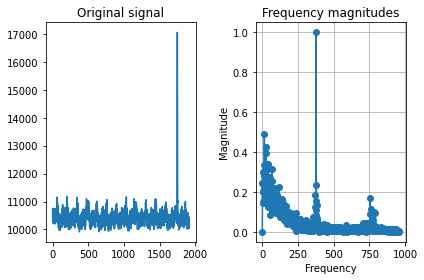

/Users/noah/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


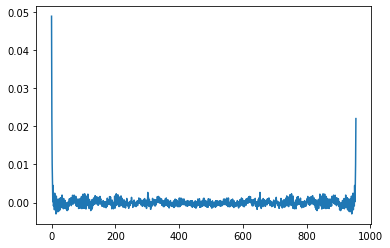

Inverse Fourier signal

The strongest frequency is f = 14.014659685863876


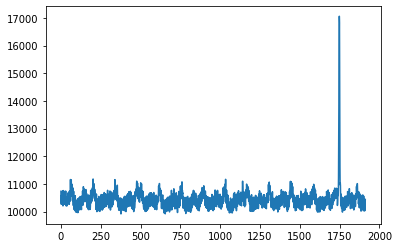

[-1.35870002e+02  7.11998705e-03  2.73707818e+00  1.04151381e+04]


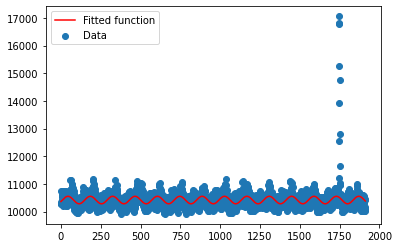

In [30]:
name_file = 'detectsat/OMEGA.2020-02-22T02:11:36.295_fullfield.fits'
radius = 15
center_line_start_y, center_line_end_y = 7302, 7697

start_line_x, start_line_y = 60, int(center_line_start_y-radius/2)
end_line_x, end_line_y = 2025, int(center_line_end_y-radius/2)

angle_line = 360 - (np.arctan((center_line_end_y-center_line_start_y) / (end_line_x-start_line_x)) * 180 / math.pi)
print(angle_line)


#height = 2000
width_line = 1900
height_line = 2*radius

data = fits.open(name_file)[0].data
line_mask = np.ones((height_line, width_line))
line_mask_rotated = ndimage.rotate(line_mask, angle_line, reshape='False')
#print(line_mask_rotated)
line_from_image = get_line_values_with_mask(line_mask_rotated, data_with_rotated_line, start_line_x, start_line_y)
createImage('line_from_image_real_data.png', line_from_image)
line_from_image_rot = ndimage.rotate(line_from_image, 360-angle_line, reshape='False')
#createImage('line_convolved.png',line_convolved)

for i in range(15):
    line_from_image_rot[:,i] = line_from_image_rot[:,20+i]
    line_from_image_rot[:,-1-i] = line_from_image_rot[:,-21-i]

rot_height, rot_width = np.shape(line_from_image_rot)

findIntensityAlongTheLine(line_from_image_rot, rot_height, rot_width, 0, 0)

## Main

In [115]:
def main(args):
    #x_star,y_star = 3274,7977
    #radius = 10
    #x_star,y_star = 2585,7765
    #radius = 5
    #x_star,y_star = 3069,7821
    #x_star,y_star = 1175,7541
    #x_star,y_star = 1639,7812
    x_star,y_star = 1665,8346
    radius = 15
    height = 2000
    width = 1900
    value = 1
    ampl, freq, phase_shift, vertical_shift = 0.5, 0.01, 0, 0.5

    blank_image = np.zeros((height,width))
    data = fits.open(args.i)[0].data
    star = data[y_star-radius:y_star+radius, x_star-radius:x_star+radius]
    height_line = 2*radius
    line = np.zeros((height_line, width))

    for i in range(height_line):
        for j in range(width):
            if(i == round(height_line/2)):
                line[i,j] = sinus(j, ampl, period, phase_shift, vertical_shift)
                #line[i,j] = value*sinus(j, ampl, period, phase_shift, vertical_shift)

    line_convolved = ndimage.convolve(line, star)
    findIntensityAlongTheLine(line, height_line, width, 0, 0)
    #showGraph(np.transpose(line_convolved))
    #Put the same value in the last row as in the first one
    line_convolved[-1,:] = line_convolved[0,:]
    line_convolved[:,:] = line_convolved[:,:]-(51.4*2)
    #createImage('line_convolved_reflect_4r.png', line_convolved)


    #data_with_line = addLineOnData(line_convolved, data, width, height_line)
    #scaled_data = scale_image(data_with_line[::-1].copy())
    #findIntensityAlongTheLine(scaled_data, height_line, width, 100, 100)
    #createImage('try_image_line_new_star_15_04_r.png', scaled_data)


    #createFitsFile(args.i, scaled_data)
    #showGraph(np.transpose(line_convolved))

In [105]:
showGraph(np.transpose(line_convolved))

NameError: name 'line_convolved' is not defined